## Building statistical solar forecasts from measurement data
#### Dragos Boros
##### Alpiq

In [135]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

from IPython.core.display import HTML
plt.style.use('seaborn')
#print(np.__version__,pd.__version__)  # check versions

In [117]:
df = pd.read_csv("solar.csv", sep =";", index_col=0, parse_dates=True, dayfirst=True)
df['production'] = df['production'].str.replace(' ', '').astype('float')
#d = df[['realized']]
#d1 =d['2016-1':'2016-8']

In [119]:
def display(*args,axis=0):
    """helper function to display dfs sided by side or on top of each other"""
    return HTML((''.join(a._repr_html_() + '<br style="clear: both;">' for a in args )
                if axis == 0 else 
                 ''.join('<div style="float: left; padding: 20px">'+a._repr_html_()+'</div>' for a in args)))

In [120]:
def compare(df1,df2):
    """helper function to compare two dfs"""
    return pd.concat([df1,df2],axis=1,keys=['original', 'transformed'])

In [144]:
def prev(df):
    """ tomorrow's forecasted values are today's realized values"""
    return df[:24].append(df.shift(1,'D')[:-24])
display (compare(df,prev(df))[12:16],compare(df,prev(df))[36:40],axis =1)

,original,transformed
,production,production
value_time,,
2016-01-01 12:00:00,612.0,612.0
2016-01-01 13:00:00,83.0,83.0
2016-01-01 14:00:00,57.0,57.0
2016-01-01 15:00:00,99.0,99.0
,original,transformed
,production,production
value_time,,
2016-01-02 12:00:00,80.0,612.0


In [122]:
def prev2(df):
    """ tomorrow's forecasted values are the average of (today's and yesterday's) realized values"""
    x = prev(df)
    return (x + prev(x) ) / 2

In [123]:
def prev3(df):
    """ tomorrow's forecasted values are the average of (today's and previous 2 days) realized values"""
    x = prev(df)
    y = prev(x)
    return (x + y + prev(y) ) / 3

In [124]:
def month_hour_avg(df):
    """ df transformed to monthly hourly averages"""
    b = df.copy()
    b['month'] = b.index.month
    b['hour']  = b.index.hour
    out = b.merge( b.groupby(['month','hour']).mean(),
                   how='left', left_on=['month', 'hour'], 
                   right_index=True, suffixes=('ignore',''))[df.columns]
    return out

In [125]:
def detect_suspicious_hours(d,threshold = 0.05, avg_threshold = 200):
    """detects hours with suspicious low production 
       such hours satisfy the folowing two conditions:
           - hourly value is smaller than the product threshold * monthly average for that hour
           - monthly average for an hour is higher than an absolute threshold
    """
    out = pd.concat([d,month_hour_avg(d)],axis=1,keys=['original', 'avg_value'])
    out.columns = out.columns.droplevel(1)
    return out.query('original < avg_value * @threshold and avg_value > @avg_threshold' )
detect_suspicious_hours(df)[:3]

,original,avg_value
value_time,,
2016-01-02 15:00:00,9.0,377.774194
2016-01-18 15:00:00,12.0,377.774194
2016-02-03 08:00:00,12.0,274.137931


In [126]:
def clear_suspicious_hours(df):
    out = df.copy()
    out.loc[detect_suspicious_hours(df).index, df.columns] = np.nan
    return out
#clear_suspicious_hours(df)[:3]

In [127]:
def replace_suspicious_values(df, compare=False):
    v = clear_suspicious_hours(df)
    x = v.copy()
    x[x.isnull()] = month_hour_avg(v)
    out = pd.concat([df,v,x],axis=1,keys=['original_production','valid_production', 'filled_production',])
    out.columns = out.columns.droplevel(1)
    return out if compare else out[['filled_production']]
#replace_suspicious_values(df, compare=True).to_clipboard()       

In [142]:
# compare raw production and statistical forecasts
def compare_forecasts(df):
    c = replace_suspicious_values(df)
    out = pd.concat([df,c,prev(df),prev2(df),prev3(df),
                     month_hour_avg(df),month_hour_avg(c)], 
                    keys=['original_production','corrected_production','prevday','prev2days','prev3days',
                          'monthavg_nocorrection','monthavg_withcorrection'], axis=1)
    out.columns = out.columns.droplevel(1)
    return out
res = compare_forecasts(df)
res.to_clipboard()

In [130]:
#z = pd.DataFrame(pd.date_range(start='2016-01-01',end='2016-09-01',freq='H')[:-1], columns=['VALUE_TIME'])

#d.groupby(d.index.month).sum() / d.sum()
#d.groupby([d.index.month, d.index.hour]).mean().unstack()

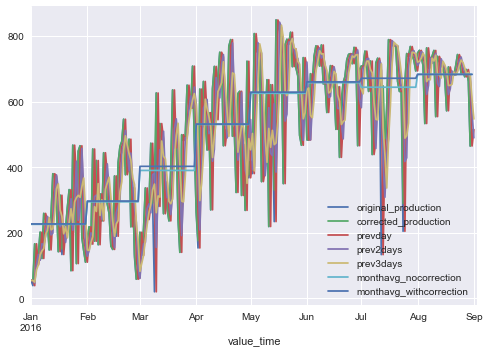

In [136]:
res.resample('D').mean().plot();

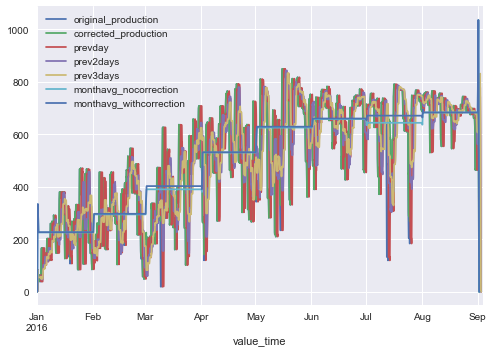

In [141]:
res.rolling('24h').mean().plot();